# Twitter US Airline Sentiment

This is my implementation for theTwitter US Airlines Sentiment Analysis using  ULMFiT model.

This analysis is heavily inspired by the following tutorials:

- [SPAM detection using fastai ULMFiT](https://blog.datascienceheroes.com/spam-detection-using-fastai-ulmfit-part-1-language-model/)
- [Simplifying Sentiment Analysis in Python](https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python)

In [1]:
from fastai import *
import pandas as pd
import numpy as np
from fastai.text import *
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

## Loading Dataset

The dataset can be download from [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv) and consists of 13,640 tweets and contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines.

In [2]:
df = pd.read_csv('data/Tweets.csv')
# in this analysis we are only interested in the tweet text
# and the assignment airline_sentiment
df = df[['airline_sentiment','text']]
df.columns = ['target','text']
df.head()

,target,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Target Distribution

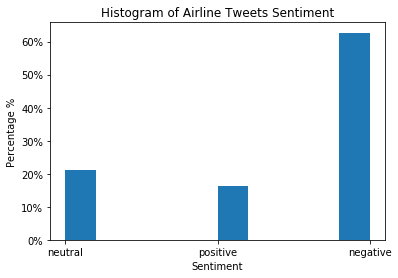

negative    9178
neutral     3099
positive    2363
Name: target, dtype: int64


In [3]:
plt.hist(df['target'], weights= np.ones(len(df))/len(df))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Sentiment')
plt.ylabel('Percentage %')
plt.title('Histogram of Airline Tweets Sentiment')
plt.show()
print(df['target'].value_counts())

## Data Exploration

We can see the most frequent words associated with each sentiment class (positive, neutral, negative). But first we have to remove stop words, punctionation and lower case the entire text. Before we proceed further we need to tokenize each tweet into a list of words. For that we will use the
`nltk.tokenize` [package](http://www.nltk.org/api/nltk.tokenize.html)

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [5]:
tokenized_data = []
for tweet in df.text:
    words = word_tokenize(tweet)
    words=np.array([word.lower() for word in words if word.isalpha() and words not in stopwords.words('english')])
    tokenized_data.append(words)
tokenized_data = np.array(tokenized_data)

In [6]:
df_tokenized = pd.DataFrame(tokenized_data,columns=['text'])
df_tokenized['target'] = df.target.values
df_tokenized.head()

,text,target
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, you, added, commercials,...",positive
2,"[virginamerica, i, did, today, must, mean, i, ...",neutral
3,"[virginamerica, it, really, aggressive, to, bl...",negative
4,"[virginamerica, and, it, a, really, big, bad, ...",negative


we will only look at the 25 most frequent word in each sentiment class.

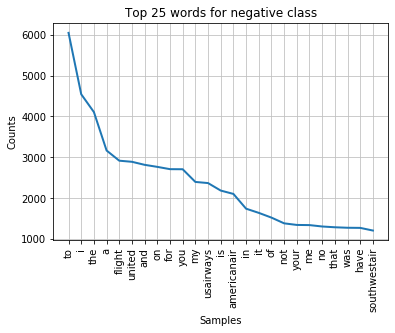

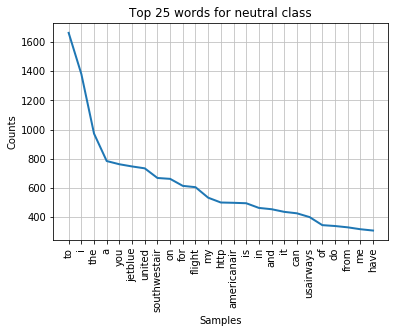

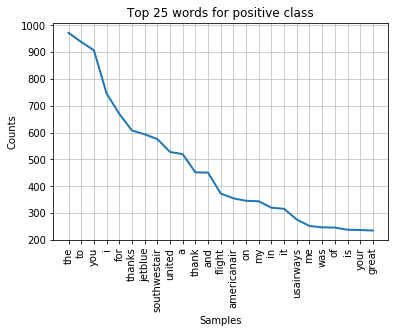

In [7]:
top_N = 25
classes = np.unique(df.target.values)
for i in range(len(classes)):
    df_cls = df_tokenized[df_tokenized['target'] == classes[i]]
    all_words = []
    for twt in df_cls.text:
        all_words.extend(twt.ravel())
        
    # sort by frequency
    all_words = nltk.FreqDist(w for w in all_words)
    all_words.plot(top_N, title=f'Top {top_N} words for {classes[i]} class')

We can make the following observations:

- The top words do not tell us something insightful but sometimes certain unique words can have very high correlation with a specific sentiment class. 
- It is interesting that ```usairways``` is mentioned much more in negative tweets while ```southwestair``` is mentioned more in positive tweets.
- Similarly, ```jetblue``` is more associated with neutral or positive sentiment.

# Train/Validation split

In [8]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, stratify=df['target'], test_size=0.2)

In [9]:
print(f"train shape: {df_train.shape}")
print(f"val shape: {df_val.shape}")

train shape: (11712, 2)
val shape: (2928, 2)


## The Language Model

We will use  ULMFiT model pretrained on 103M wikipedia articles using [AWS_LSTM architecture](https://docs.fast.ai/text.models.html#Language-model-modules). As such we do not need to train the model from scratch and we just need to fine tune the model for our task.

since ULMFiT model is a language model that was trained on a large corpus we do not need to do prerocessing of removing capitalization of stop words since they are part of the language and might be used by the model.

In [10]:
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_val, path = "")

In [11]:
language_model = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult=1.)

## Model Fine Tuning

we will use ```lr_find``` function to find the best learning rate and then use it in ```fit_one_cycle``` to train for 4 epochs.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 6.31E-02


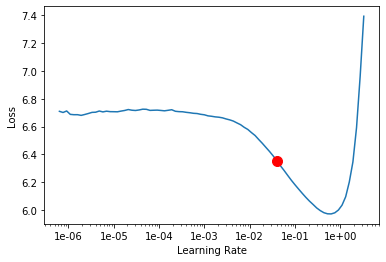

In [12]:
language_model.lr_find()
language_model.recorder.plot(suggestion=True)

The best learning rate is aroung ```5e-02```, we will use this value in our call to ```fit_one_cycle``` function for 4 epochs.

In [13]:
language_model.fit_one_cycle(cyc_len=4, max_lr=slice(5e-2/(2.6 ** 4),5e-02))

epoch,train_loss,valid_loss,accuracy,time
0,4.943951,4.044016,0.248293,01:08
1,4.429381,4.002926,0.255055,01:07
2,4.122308,3.895153,0.267673,01:07
3,3.871207,3.862485,0.271652,01:09


We will continue to do the same by unfreezing a layer, finding the best learning rate and then fine tuning.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-05


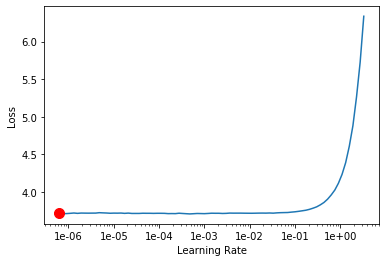

In [14]:
language_model.freeze_to(-1)
language_model.lr_find()
language_model.recorder.plot(suggestion=True)

In [15]:
# train the model using the best learning rate
language_model.fit_one_cycle(3, max_lr=slice(1e-6/(2.6 ** 4),1e-06))

epoch,train_loss,valid_loss,accuracy,time
0,3.717452,3.862047,0.272151,01:08
1,3.713162,3.862159,0.271849,01:07
2,3.706953,3.861713,0.272085,01:07


#### same thing for the next layer

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.91E-07


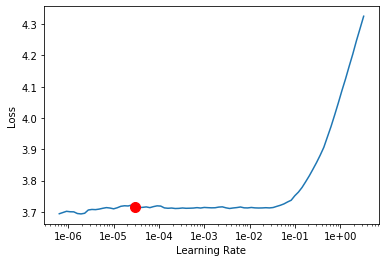

In [16]:
language_model.freeze_to(-2)
language_model.lr_find()
language_model.recorder.plot(suggestion=True)

In [17]:
# train the model using the best learning rate
language_model.fit_one_cycle(3, max_lr=slice(5e-05/(2.6 ** 4),5e-05))

epoch,train_loss,valid_loss,accuracy,time
0,3.720014,3.858200,0.272531,01:10
1,3.712442,3.854147,0.272742,01:10
2,3.711082,3.854535,0.272912,01:10


In [18]:
#save the model
language_model.save_encoder('twitter_encoder')

## Sentiment Classifier

In [19]:
data_classifier = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_val, vocab = data_lm.train_ds.vocab, bs=32)

In [20]:
sentiment_classifer = text_classifier_learner(data_classifier, drop_mult=0.7, arch = AWD_LSTM)

In [21]:
sentiment_classifer.load_encoder('twitter_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos @united xxmaj not xxunk that i 'll have my xxup cpap tonight .,xxbos @united xxmaj why is n't the flight status updated to delayed xxup xxunk no board,xxbos @americanair xxmaj xxunk customers to fill out all the contact information each time seems designed to prevent or limit interaction .,xxbos @usairways this is ridiculous . i have a xxunk xxup am flight and two hours of rest , wasted ! ! !,xxbos @united tried that already & & tried forgetting the wifi network connection . xxmaj still forces log in with incorrect email . xxmaj other suggestions ?
y: CategoryList
negative,negative,negative,negative,negative
Path: .;

Valid: LabelList (2928 items)
x: TextList
xxbos @united wonderful bag claim people - finally have my bag . xxmaj but why did i catch earlier flight ? xxmaj original flight just landed . # xxunk,xxbos @usairways xxmaj its not just xxup phl , at xxup btv today made to deplane because " it '

## Training the classifier

similar to what we did in fine tuning the language model, we will find the best learning rate, usr ```fit_one_cycle``` function.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 1.20E-02


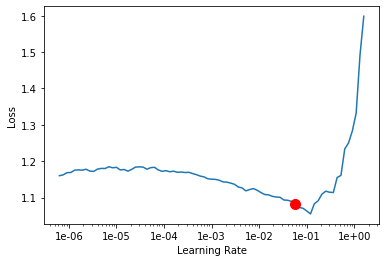

In [22]:
sentiment_classifer.lr_find()
sentiment_classifer.recorder.plot(suggestion=True)

In [23]:
sentiment_classifer.fit_one_cycle(cyc_len=5, max_lr=8e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.762863,0.611162,0.768443,02:32
1,0.821231,0.765712,0.675205,02:30
2,0.731134,0.597463,0.762978,02:35
3,0.756498,0.601435,0.770492,02:36
4,0.703684,0.592807,0.770833,02:06


we can plot the training and validation loss

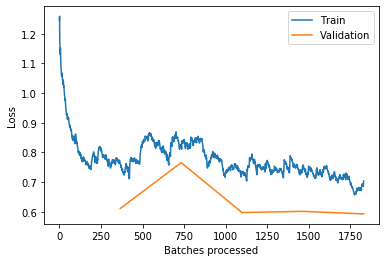

In [24]:
sentiment_classifer.recorder.plot_losses()

In [25]:
sentiment_classifer.save_encoder('classifer_encoder')

## Evaluating the Classifier

In [26]:
validation_preds, validation_labels = sentiment_classifer.get_preds(ds_type=DatasetType.Valid, ordered=True)

In [27]:
train_preds, train_labels = sentiment_classifer.get_preds(ds_type=DatasetType.Train, ordered=True)

In [28]:
from sklearn.metrics import roc_curve, auc

In [29]:
# calculate auc scores for each class
fpr = {}
tpr = {}
roc_auc = {}
classes = ['negative', 'neutral','positive']
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(df_val.target == classes[i], validation_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

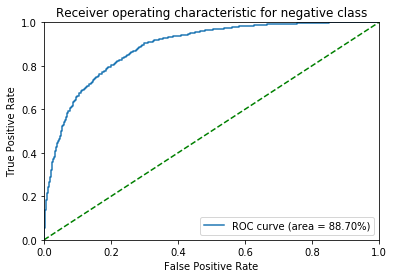

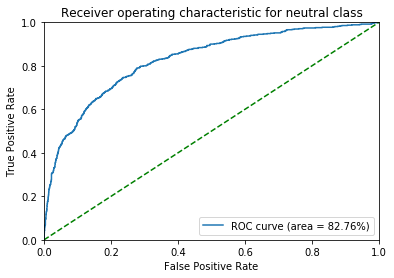

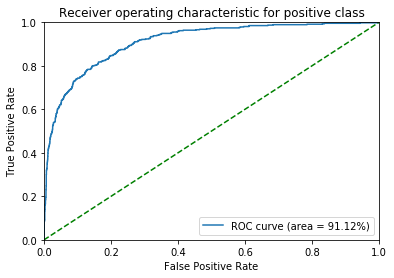

In [30]:
# Plot of a ROC curve for a specific class
for i in range(len(classes)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2%})')
    plt.plot([0, 1], [0, 1], 'g--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic for {classes[i]} class')
    plt.legend(loc='lower right')
    plt.show()

we can also calculate the average AUC score among classes

In [31]:
auc = np.mean(list(roc_auc.values()))
print(f"AUC = {auc:0.2%}")

AUC = 87.53%
